In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch

In [50]:
def lorentz(init, length, T, p=10., r=28., b=8/3):
    interval = T / length
    pos = []
    prev_pos = init
    pos.append(prev_pos)
    for i in range(length):
        next_pos = torch.zeros(3)
        next_pos[0] = prev_pos[0] + interval * (-p*(prev_pos[0] - prev_pos[1]))
        next_pos[1] = prev_pos[1] + interval * (-prev_pos[0]*prev_pos[2] + r*prev_pos[0] - prev_pos[1])
        next_pos[2] = prev_pos[2] + interval * (prev_pos[0]*prev_pos[1] - b*prev_pos[2])
        pos.append(next_pos)
        prev_pos = next_pos
    pos = torch.stack(pos)
    return pos

def VanDelPol(init, length, T, eps=0.3):
    interval = T / length
    pos = []
    prev_pos = init
    pos.append(prev_pos)
    for i in range(length):
        next_pos = torch.zeros(2)
        next_pos[0] = prev_pos[0] + interval * (prev_pos[1])
        next_pos[1] = prev_pos[1] + interval * (-prev_pos[0] + eps*prev_pos[1]*(1 - prev_pos[0]*prev_pos[0]))
        pos.append(next_pos)
        prev_pos = next_pos
    pos = torch.stack(pos)
    return pos


def Nonlinear(init, length, T):
    interval = T / length
    pos = []
    prev_pos = init
    pos.append(prev_pos)
    for i in range(length):
        next_pos = torch.zeros(1)
        # next_pos[0] = prev_pos[0] + interval * (-prev_pos[0] * prev_pos[0] * prev_pos[0])
        next_pos[0] = prev_pos[0] + interval * (-prev_pos[0] * prev_pos[0] + prev_pos[0])
        pos.append(next_pos)
        prev_pos = next_pos
    pos = torch.stack(pos)
    return pos

In [51]:
# init = torch.tensor([1.,1.,1.])
# length = 1000
# T = 10
# pos = lorentz(init, length, T)

# init = torch.tensor([1.,10.])
# length = 10000
# T = 100
# pos = VanDelPol(init, length, T, eps=5.)

init = torch.tensor([1.])
length = 10000
T = 100
pos = Nonlinear(init, length, T)

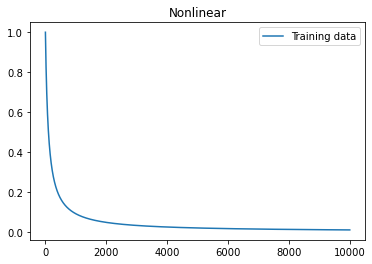

In [52]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# plt.rcParams["font.size"] = 10
# plt.plot(pos[:,0], pos[:,1], pos[:,2] , label="Training data")
# plt.title("Lorentz Curves")
# plt.legend()
# fig.savefig("Lorentz"+".png")

# fig = plt.figure()
# ax = fig.add_subplot()
# plt.rcParams["font.size"] = 10
# plt.plot(pos[:,0], pos[:,1], label="Training data")
# plt.title("Van Del Pol")
# plt.legend()
# fig.savefig("Lorentz"+".png")

fig = plt.figure()
ax = fig.add_subplot()
plt.rcParams["font.size"] = 10
plt.plot(pos[:,0], label="Training data")
plt.title("Nonlinear")
plt.legend()